In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
covid = pd.read_csv(r'C:\Users\Lenovo\Downloads\us-counties.csv')
covid["date"] = pd.to_datetime(covid["date"])
covid = covid.set_index('date').to_period('D')

In [4]:
covid = covid.fillna(0)
covid

,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
date,,,,,,,,,
2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.00,0.00
2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2021-09-29,USA-69120,Tinian,Northern Mariana Islands,0,0.00,0.00,0,0.00,0.00
2021-09-29,USA-69110,Saipan,Northern Mariana Islands,0,0.43,0.89,0,0.00,0.00
2021-09-29,USA-78030,St. Thomas,Virgin Islands,7,5.00,9.68,1,0.14,0.28


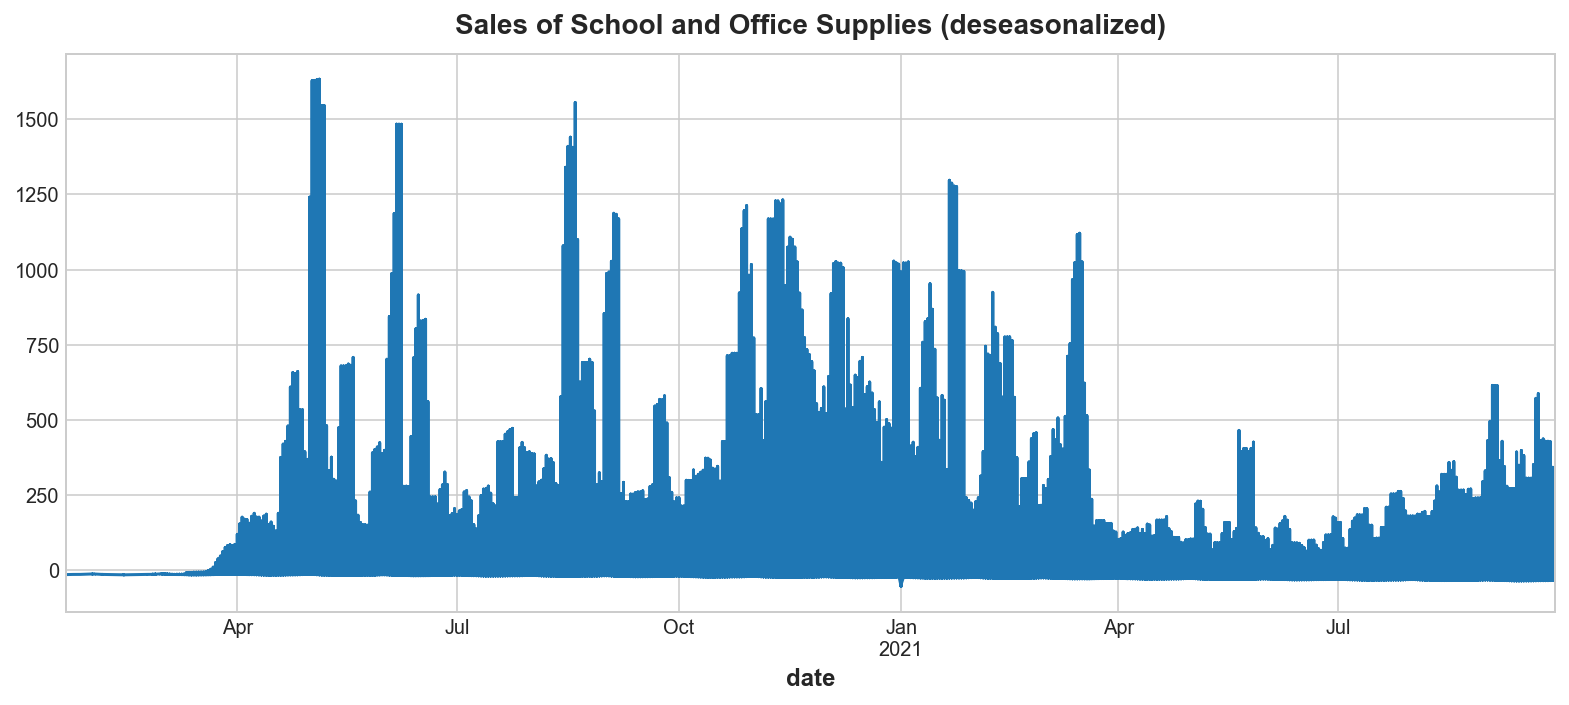

In [5]:
y = covid.loc[:, 'cases_avg_per_100k'].squeeze()
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

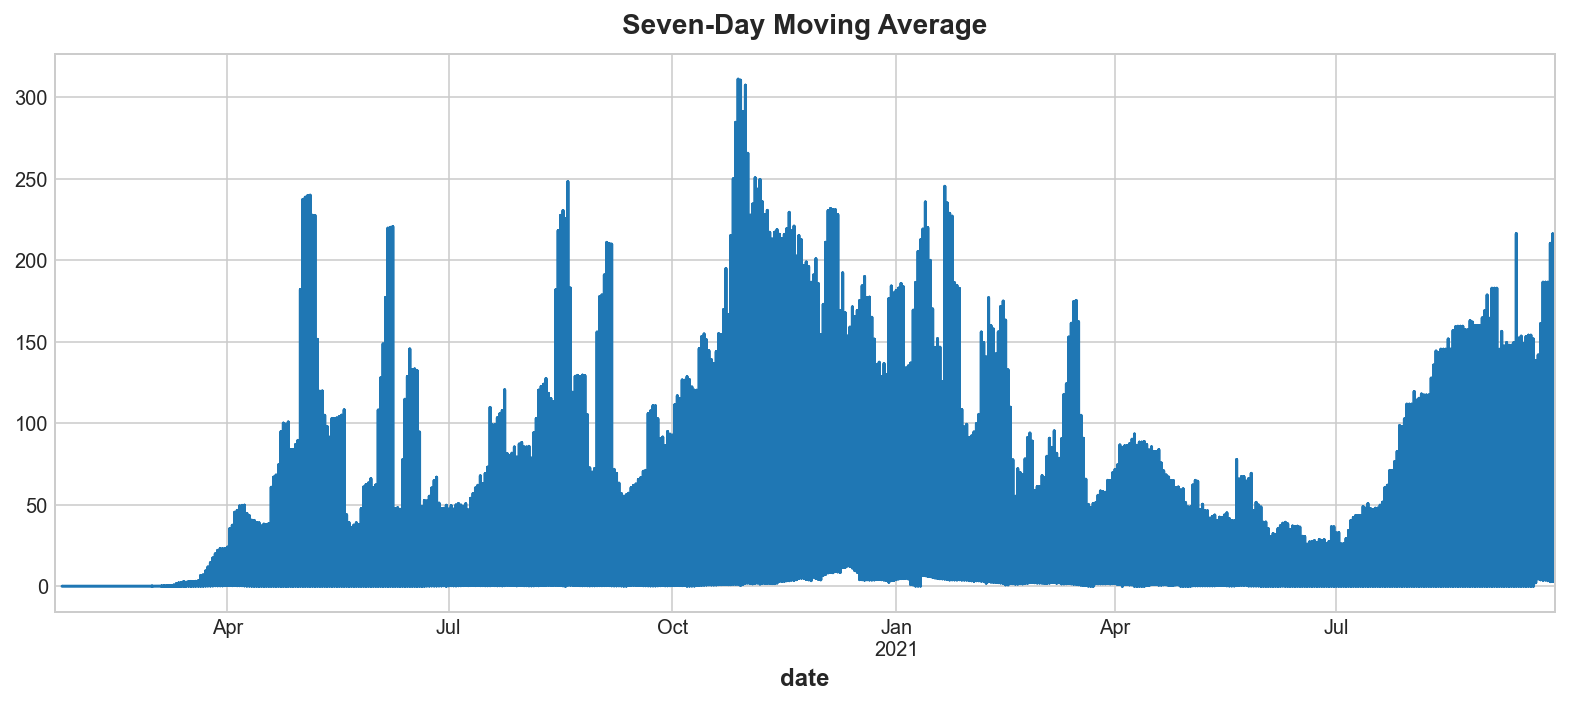

In [6]:
y_ma = y.rolling(7, center=True).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

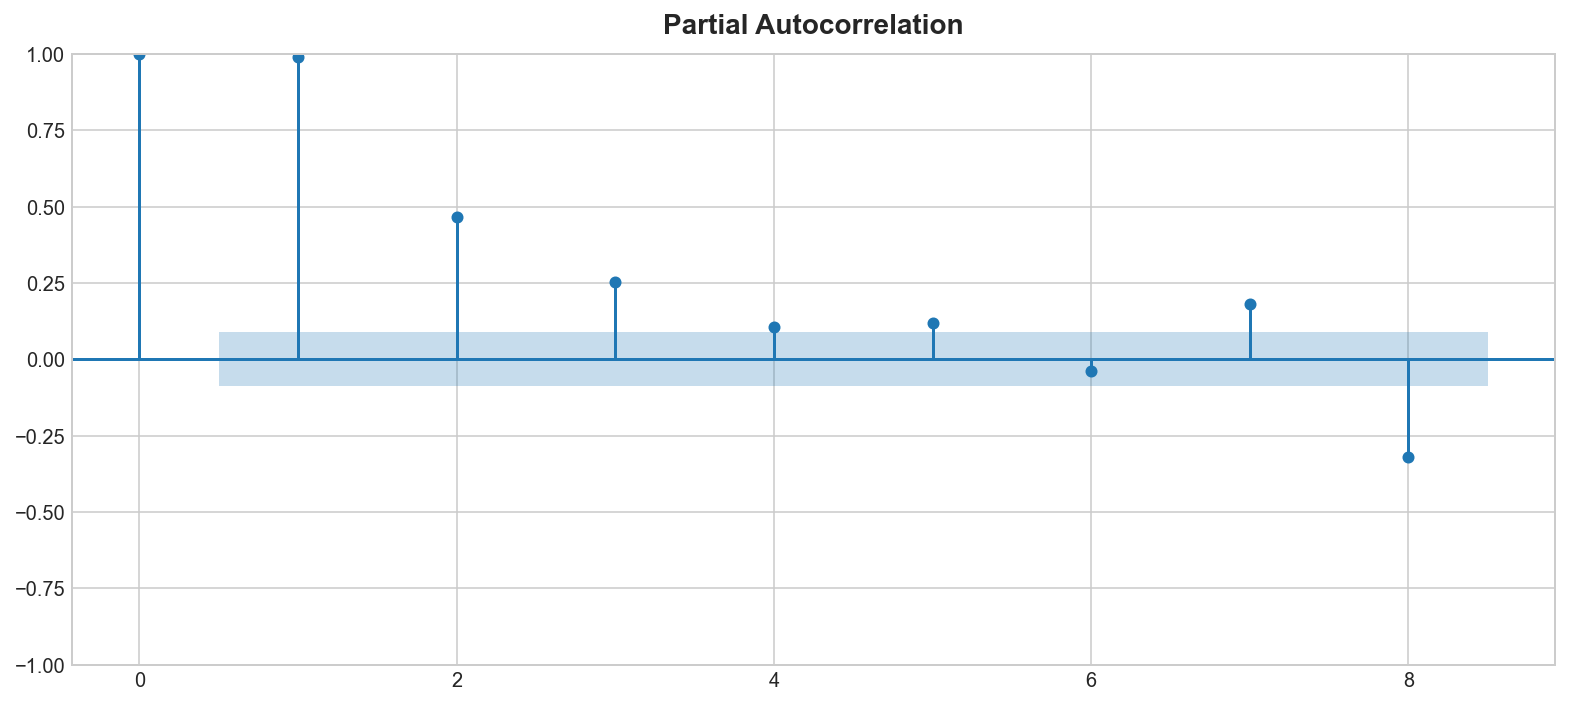

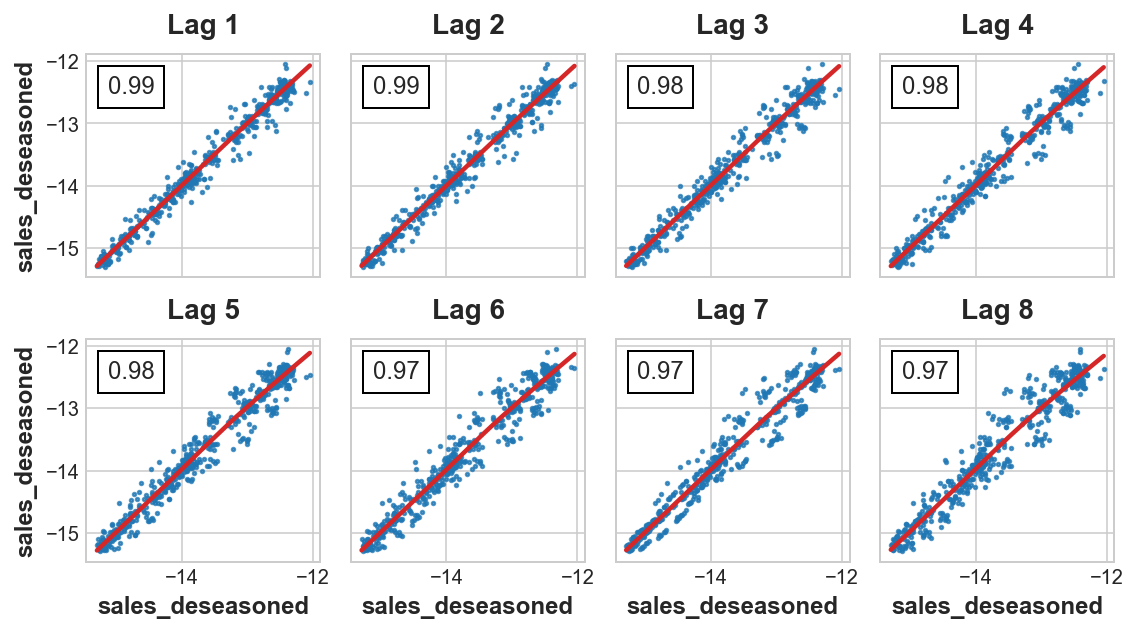

In [8]:
_ = plot_pacf(y_deseason[:500], lags=8);
_ = plot_lags(y_deseason[:500], lags=8, nrows=2);

Training RMSLE: 2.38984
Validation RMSLE: 3.12892


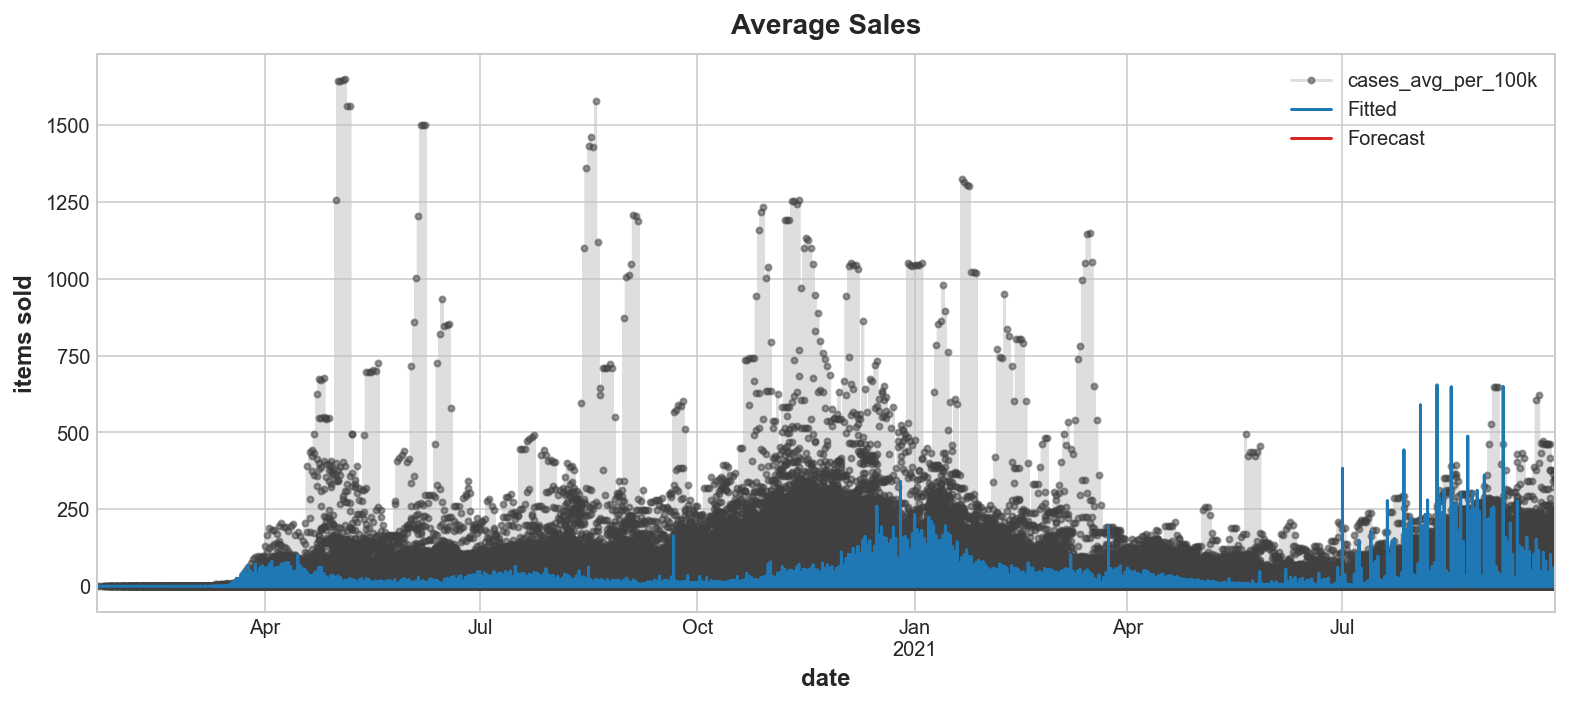

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

In [16]:
y_lag = covid.loc[:, 'cases'].shift(1)
deaths = covid.loc[:, 'deaths']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# YOUR CODE HERE: 7-day sum of promotions with centered window
promo_7 = deaths.rolling(7, center = True).sum()